### Making call to data generator to get the .csv files


In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import subprocess
from sklearn.model_selection import train_test_split
from pathlib import Path
import os

In [30]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / ".." / ".."))


In [31]:
from source.sp_data_generator.supply_planning_data_generator import SupplyPlanningDataGenerator

In [21]:
generator = SupplyPlanningDataGenerator(seed=42)

# Generate a complete dataset
dataset = generator.generate_full_dataset(
    num_products=20,
    num_facilities=5,
    periods=52,
    frequency='W',  # Weekly data
    start_date='2023-01-01'
)

for key in dataset.keys():
    key_str = str(key) + ".csv"
    df = dataset[key]
    file_path = os.path.join("data", key_str)
    df.to_csv(file_path, index=True)




In [22]:
#Only get first 4 products to test model
df = pd.read_csv("data/demand.csv")
prod_list = ['P0001', 'P0002', 'P0003', 'P0004']
demand_abbreviated_df = df[df['product_id'].isin(prod_list)]


In [23]:
# Adding a month feature column taken from the data column, encoded as a number 1-12, also encouding the facilitys 1 through 3
demand_abbreviated_df["day_of_year"] = pd.to_datetime(demand_abbreviated_df['date']).dt.dayofyear
demand_abbreviated_df["Month"] = demand_abbreviated_df['date'].str[5:7].astype(int)
demand_abbreviated_df["facility_id"] = demand_abbreviated_df["facility_id"].str[2:].astype(int)
demand_abbreviated_df.drop(columns=['date'], inplace=True)



/var/folders/1y/9ylqcnz53wq648vdrx0nnt2w0000gn/T/ipykernel_70527/1660942486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_abbreviated_df["day_of_year"] = pd.to_datetime(demand_abbreviated_df['date']).dt.dayofyear
/var/folders/1y/9ylqcnz53wq648vdrx0nnt2w0000gn/T/ipykernel_70527/1660942486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_abbreviated_df["Month"] = demand_abbreviated_df['date'].str[5:7].astype(int)
/var/folders/1y/9ylqcnz53wq648vdrx0nnt2w0000gn/T/ipykernel_70527/166094248

In [24]:
demand_abbreviated_df["demand"].describe()
demand_abbreviated_df.head(150)

,Unnamed: 0,product_id,facility_id,demand,day_of_year,Month
0,0,P0001,1,459,1,1
1,1,P0001,1,662,8,1
2,2,P0001,1,561,15,1
3,3,P0001,1,864,22,1
4,4,P0001,1,672,29,1
...,...,...,...,...,...,...
145,145,P0001,3,482,288,10
146,146,P0001,3,640,295,10
147,147,P0001,3,618,302,10
148,148,P0001,3,589,309,11


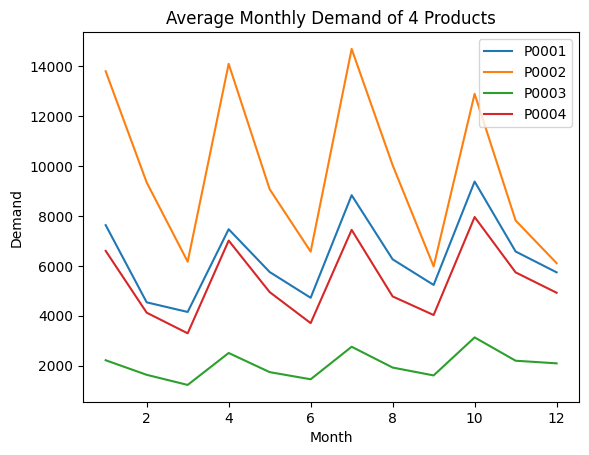

In [25]:
result_item1 = demand_abbreviated_df[demand_abbreviated_df['product_id'] == 'P0001']
df_month_sum1 = result_item1.groupby(['Month']).sum()['demand']

result_item2 = demand_abbreviated_df[demand_abbreviated_df['product_id'] == 'P0002']
df_month_sum2 = result_item2.groupby(['Month']).sum()['demand']

result_item3 = demand_abbreviated_df[demand_abbreviated_df['product_id'] == 'P0003']
df_month_sum3 = result_item3.groupby(['Month']).sum()['demand']

result_item4 = demand_abbreviated_df[demand_abbreviated_df['product_id'] == 'P0004']
df_month_sum4 = result_item4.groupby(['Month']).sum()['demand']

fig, ax = plt.subplots(1,1)
df_month_sum1.plot(x='Month', y='demand', label='P0001')
df_month_sum2.plot(x='Month', y='demand', label='P0002')
df_month_sum3.plot(x='Month', y='demand', label='P0003')
df_month_sum4.plot(x='Month', y='demand', label='P0004')

ax.set_xlabel('Month')
ax.set_ylabel('Demand')
ax.set_title('Average Monthly Demand of 4 Products')
ax.legend()
plt.show()

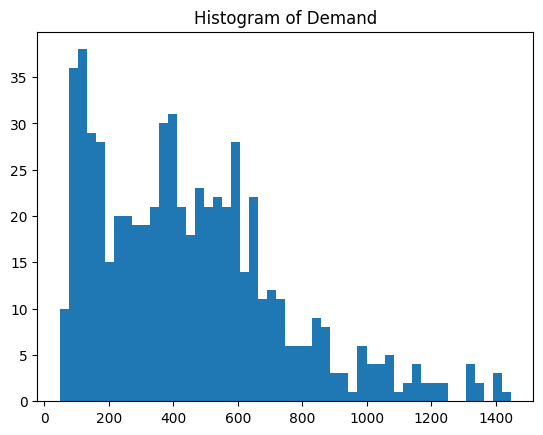

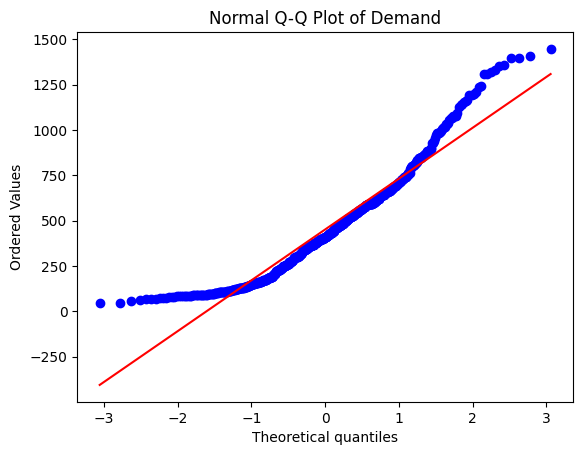

ShapiroResult(statistic=np.float64(0.9323401776607577), pvalue=np.float64(3.4594275844078817e-16))


In [26]:
demand_total = demand_abbreviated_df['demand']
plt.hist(demand_total, bins=50)
plt.title('Histogram of Demand')
plt.show()

stats.probplot(demand_total, dist='norm', plot=plt)
plt.title('Normal Q-Q Plot of Demand')
plt.show()

print(stats.shapiro(demand_total))

In [27]:
demand_abbreviated_df['product_id'] = demand_abbreviated_df['product_id'].str[3:].astype(int)

/var/folders/1y/9ylqcnz53wq648vdrx0nnt2w0000gn/T/ipykernel_70527/1077127334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_abbreviated_df['product_id'] = demand_abbreviated_df['product_id'].str[3:].astype(int)


In [28]:
from sklearn.metrics import mean_squared_error

X = demand_abbreviated_df.drop(columns=['demand'])
y = demand_abbreviated_df['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 34061.15625
